# Importing libraries

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import inspect
from pathlib import Path
import matplotlib.pyplot as plt

# Loading data file

In [15]:
# Path for merged HH and Person first-visit file
file_path_1 =  r'..\PLFS 2023-24\Extracted_files\HHV1_PERV1_merged.dta'

In [16]:
# Checking if path exists
Path(file_path_1).exists()

True

In [19]:
# Loading as dataframe
df = pd.read_stata(file_path_1).copy()

# Changing data formats

In [20]:
#Changing to numeric
df[["pvar32", "pvar43", "usual_status_code", "pvar20", "weights"]] = df[["pvar32", "pvar43", "usual_status_code", "pvar20", "weights"]].apply(pd.to_numeric)

# New columns

In [21]:
#Creating a new column with 2 digit NIC codes based on usual status

#Assigning NIC code based on usual status
df["usual_status_ind"] = df.apply(lambda row: row["pvar44"] if ((row["pvar32"]>=81) & pd.notna(row["pvar43"])) else row["pvar33"], axis=1 )

#Keeping only the first two NIC digits
df["usual_status_ind"] = df["usual_status_ind"].astype(str).str[:2]
df["usual_status_ind"] = df["usual_status_ind"].apply(pd.to_numeric)

In [22]:
#Categorising NIC codes into industry categories

#Codes based classification
conditions = [(df["usual_status_ind"]>=1) & (df["usual_status_ind"]<=3),
              (df["usual_status_ind"]>=5) & (df["usual_status_ind"]<=9),
              (df["usual_status_ind"]>=10) & (df["usual_status_ind"]<=33),
              (df["usual_status_ind"]>=35) & (df["usual_status_ind"]<=39),
              (df["usual_status_ind"]>=41) & (df["usual_status_ind"]<=43),
              (df["usual_status_ind"]>=45) & (df["usual_status_ind"]<=47),
              (df["usual_status_ind"]>=49) & (df["usual_status_ind"]<=53),
              (df["usual_status_ind"]>=55) & (df["usual_status_ind"]<=56),
              (df["usual_status_ind"]>=58) & (df["usual_status_ind"]<=99),
              ]

#Categories
choices = ["Agriculture", "Mining and quarrying", "Manufacturing", "Electricity and water supply", "Construction", "Trade", "Transport", "Accomodation and food services", "Other sevices"]

#Assigning codes to categries
df["usual_status_ind_category"] = np.select(conditions, choices, default = None)

In [23]:
df.head()

,hhvar1,hhvar2,hhvar3,hhvar4,hhvar5,hhvar6,hhvar7,hhvar8,hhvar9,hhvar10,...,pvar136,pvar137,pvar138,pvar139,perid,_merge,weights,usual_status_code,usual_status_ind,usual_status_ind_category
0,FVH7,104,Q1,V1,1,02,04,021,01,14,...,2,4,246798,4,Q1V1110002110101,both,308,94.0,NaN,None
1,FVH7,104,Q1,V1,1,02,04,021,01,14,...,2,4,246798,4,Q1V1110002110102,both,308,93.0,NaN,None
2,FVH7,104,Q1,V1,1,02,04,021,01,14,...,2,4,246798,4,Q1V1110002110103,both,308,11.0,1.0,Agriculture
3,FVH7,104,Q1,V1,1,02,04,021,01,14,...,2,4,246798,4,Q1V1110002110104,both,308,21.0,1.0,Agriculture
4,FVH7,104,Q1,V1,1,02,04,021,01,14,...,2,4,246798,4,Q1V1110002110105,both,308,91.0,NaN,None


# Analysis

In [24]:
#Defining function to tabulate frequencies and percentage shares

def tabulate (table, column):
    grouped_table = table.groupby(by = column, dropna = False, as_index = False)                          #Group table by selected column
    agg_table = grouped_table.agg(
        population_size = ("weights", "sum"),                                #Popn size for each category in selected column
        sample_size = ("weights", "size")                                    #Sample size for each category in selected column
    )
    popn_sum = agg_table[pd.notnull(agg_table[column])]['population_size'].sum()          #Summing non-null values
    agg_table['population_percentage'] = agg_table['population_size']*(100/popn_sum)      #Calculating popn shares. Ignore for NA. Remember to put (100/popn_sum) in one bracket.
    agg_table['population_percentage'] = agg_table['population_percentage'].round(2)      #Round percentage to 2 digits
    agg_table = agg_table.sort_values(by = 'population_size',ascending = False)           #Sorting table based on percentage share
    agg_table = agg_table.reset_index(drop = True)                                        #Resetting index
    return agg_table

In [25]:
tabulate(df,'usual_status_ind').sort_values(by = 'usual_status_ind')

,usual_status_ind,population_size,sample_size,population_percentage
1,1.0,237873713,70591,45.24
25,2.0,2673201,877,0.51
30,3.0,1697843,665,0.32
64,5.0,374745,184,0.07
84,6.0,42734,26,0.01
...,...,...,...,...
33,94.0,1556950,653,0.30
26,95.0,2464087,948,0.47
17,96.0,4752675,1923,0.90
11,97.0,6890164,2838,1.31


# Plotting

### Principal to subsidiary complementatiry

In [26]:
# Filtering principal and subsidiary NIC codes
df_filtered = df[['pvar33', 'pvar44']]                                                              #Principal and subsidiary NIC filter
df_filtered = df_filtered[~df_filtered.eq('').any(axis = 1)]                                        #Only keeping rows with both principal and subsidiary NIC
df_filtered[['pvar33','pvar44']] = df_filtered[['pvar33','pvar44']].apply(lambda col: col.str[:2])  #Reducing NIC to 2 digits

In [27]:
df_filtered.head()

,pvar33,pvar44
9,84,01
10,01,01
12,01,42
16,94,01
19,41,01


In [28]:
#Function to categoriese 2 digit NIC codes into divisions

def nic_division(number):
    if number in range(1, 3 + 1):
        return 'Agriculture, forestry and fishing'
    elif number in range(5, 9 + 1):
        return 'Mining and quarrying'
    elif number in range(10, 33 + 1):
        return 'Manufacturing'
    elif number in range(35, 35 + 1):
        return 'Electricity, gas, steam and air conditioning supply'
    elif number in range(36, 39 + 1):
        return 'Water supply; sewerage, waste management and remediation activities'
    elif number in range(41, 43 + 1):
        return 'Construction'
    elif number in range(45, 47 + 1):
        return 'Wholesale and retail trade; repair of motor vehicles and motorcycles'
    elif number in range(49, 53 + 1):
        return 'Transportation and storage'
    elif number in range(55, 56 + 1):
        return 'Accommodation and food service activities'
    elif number in range(58, 63 + 1):
        return 'Information and communication'
    elif number in range(64, 66 + 1):
        return 'Financial and insurance activities'
    elif number in range(68, 68 + 1):
        return 'Real estate activities'
    elif number in range(69, 75 + 1):
        return 'Professional, scientific and technical activities'
    elif number in range(77, 82 + 1):
        return 'Administrative and support service activities'
    elif number in range(84, 84 + 1):
        return 'Public administration and defense; compulsory social security'
    elif number in range(85, 85 + 1):
        return 'Education'
    elif number in range(86, 88 + 1):
        return 'Human health and social work activities'
    elif number in range(90, 93 + 1):
        return 'Arts, entertainment and recreation'
    elif number in range(94, 96 + 1):
        return 'Other service activities'
    elif number in range(97, 98 + 1):
        return 'Activities of households for own use'
    elif number in range(99, 99 + 1):
        return 'Activities of extraterritorial organizations and bodies'
    else:
        return 'Unknown division or None'

In [29]:
# Assigning 2 digit NIC into divisions
df_filtered[["principal_ind", "subsidiary_ind"]] = df_filtered[['pvar33','pvar44']].astype(int).map(nic_division)

In [30]:
df_filtered.head()

,pvar33,pvar44,principal_ind,subsidiary_ind
9,84,01,Public administration and defense; compulsory ...,"Agriculture, forestry and fishing"
10,01,01,"Agriculture, forestry and fishing","Agriculture, forestry and fishing"
12,01,42,"Agriculture, forestry and fishing",Construction
16,94,01,Other service activities,"Agriculture, forestry and fishing"
19,41,01,Construction,"Agriculture, forestry and fishing"


In [31]:
#Counting Principal and subsidiary tuple values
df_filtered = df_filtered.groupby(['principal_ind', 'subsidiary_ind'], as_index=False).size()

In [32]:
# Pivoting dataframe for heatmap
df_filtered = df_filtered.pivot(index = 'principal_ind', columns = 'subsidiary_ind', values = 'size').sort_index(ascending = False)

In [33]:
df_filtered

subsidiary_ind,Accommodation and food service activities,Activities of households for own use,Administrative and support service activities,"Agriculture, forestry and fishing","Arts, entertainment and recreation",Construction,Education,"Electricity, gas, steam and air conditioning supply",Financial and insurance activities,Human health and social work activities,Information and communication,Manufacturing,Mining and quarrying,Other service activities,"Professional, scientific and technical activities",Public administration and defense; compulsory social security,Real estate activities,Transportation and storage,"Water supply; sewerage, waste management and remediation activities",Wholesale and retail trade; repair of motor vehicles and motorcycles
principal_ind,,,,,,,,,,,,,,,,,,,,
Wholesale and retail trade; repair of motor vehicles and motorcycles,39.0,5.0,20.0,2248.0,7.0,149.0,11.0,NaN,11.0,6.0,9.0,137.0,1.0,46.0,10.0,6.0,18.0,43.0,3.0,94.0
"Water supply; sewerage, waste management and remediation activities",NaN,NaN,3.0,95.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,1.0,NaN,7.0,NaN,3.0
Transportation and storage,15.0,3.0,6.0,1226.0,8.0,79.0,3.0,NaN,5.0,2.0,2.0,41.0,1.0,8.0,1.0,3.0,8.0,21.0,4.0,55.0
Real estate activities,2.0,NaN,NaN,27.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,NaN,2.0,1.0,NaN,NaN,2.0,NaN,5.0
Public administration and defense; compulsory social security,8.0,2.0,1.0,405.0,1.0,7.0,2.0,NaN,NaN,1.0,1.0,19.0,NaN,4.0,1.0,NaN,2.0,12.0,NaN,21.0
"Professional, scientific and technical activities",2.0,NaN,3.0,71.0,3.0,6.0,3.0,NaN,3.0,NaN,3.0,3.0,NaN,1.0,8.0,NaN,2.0,2.0,NaN,7.0
Other service activities,8.0,4.0,5.0,296.0,5.0,20.0,4.0,NaN,2.0,2.0,1.0,15.0,1.0,20.0,1.0,NaN,2.0,10.0,1.0,30.0
Mining and quarrying,1.0,NaN,NaN,97.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2.0,2.0,1.0,2.0
Manufacturing,27.0,8.0,12.0,2119.0,13.0,249.0,13.0,1.0,7.0,4.0,3.0,121.0,2.0,45.0,5.0,4.0,6.0,27.0,2.0,140.0


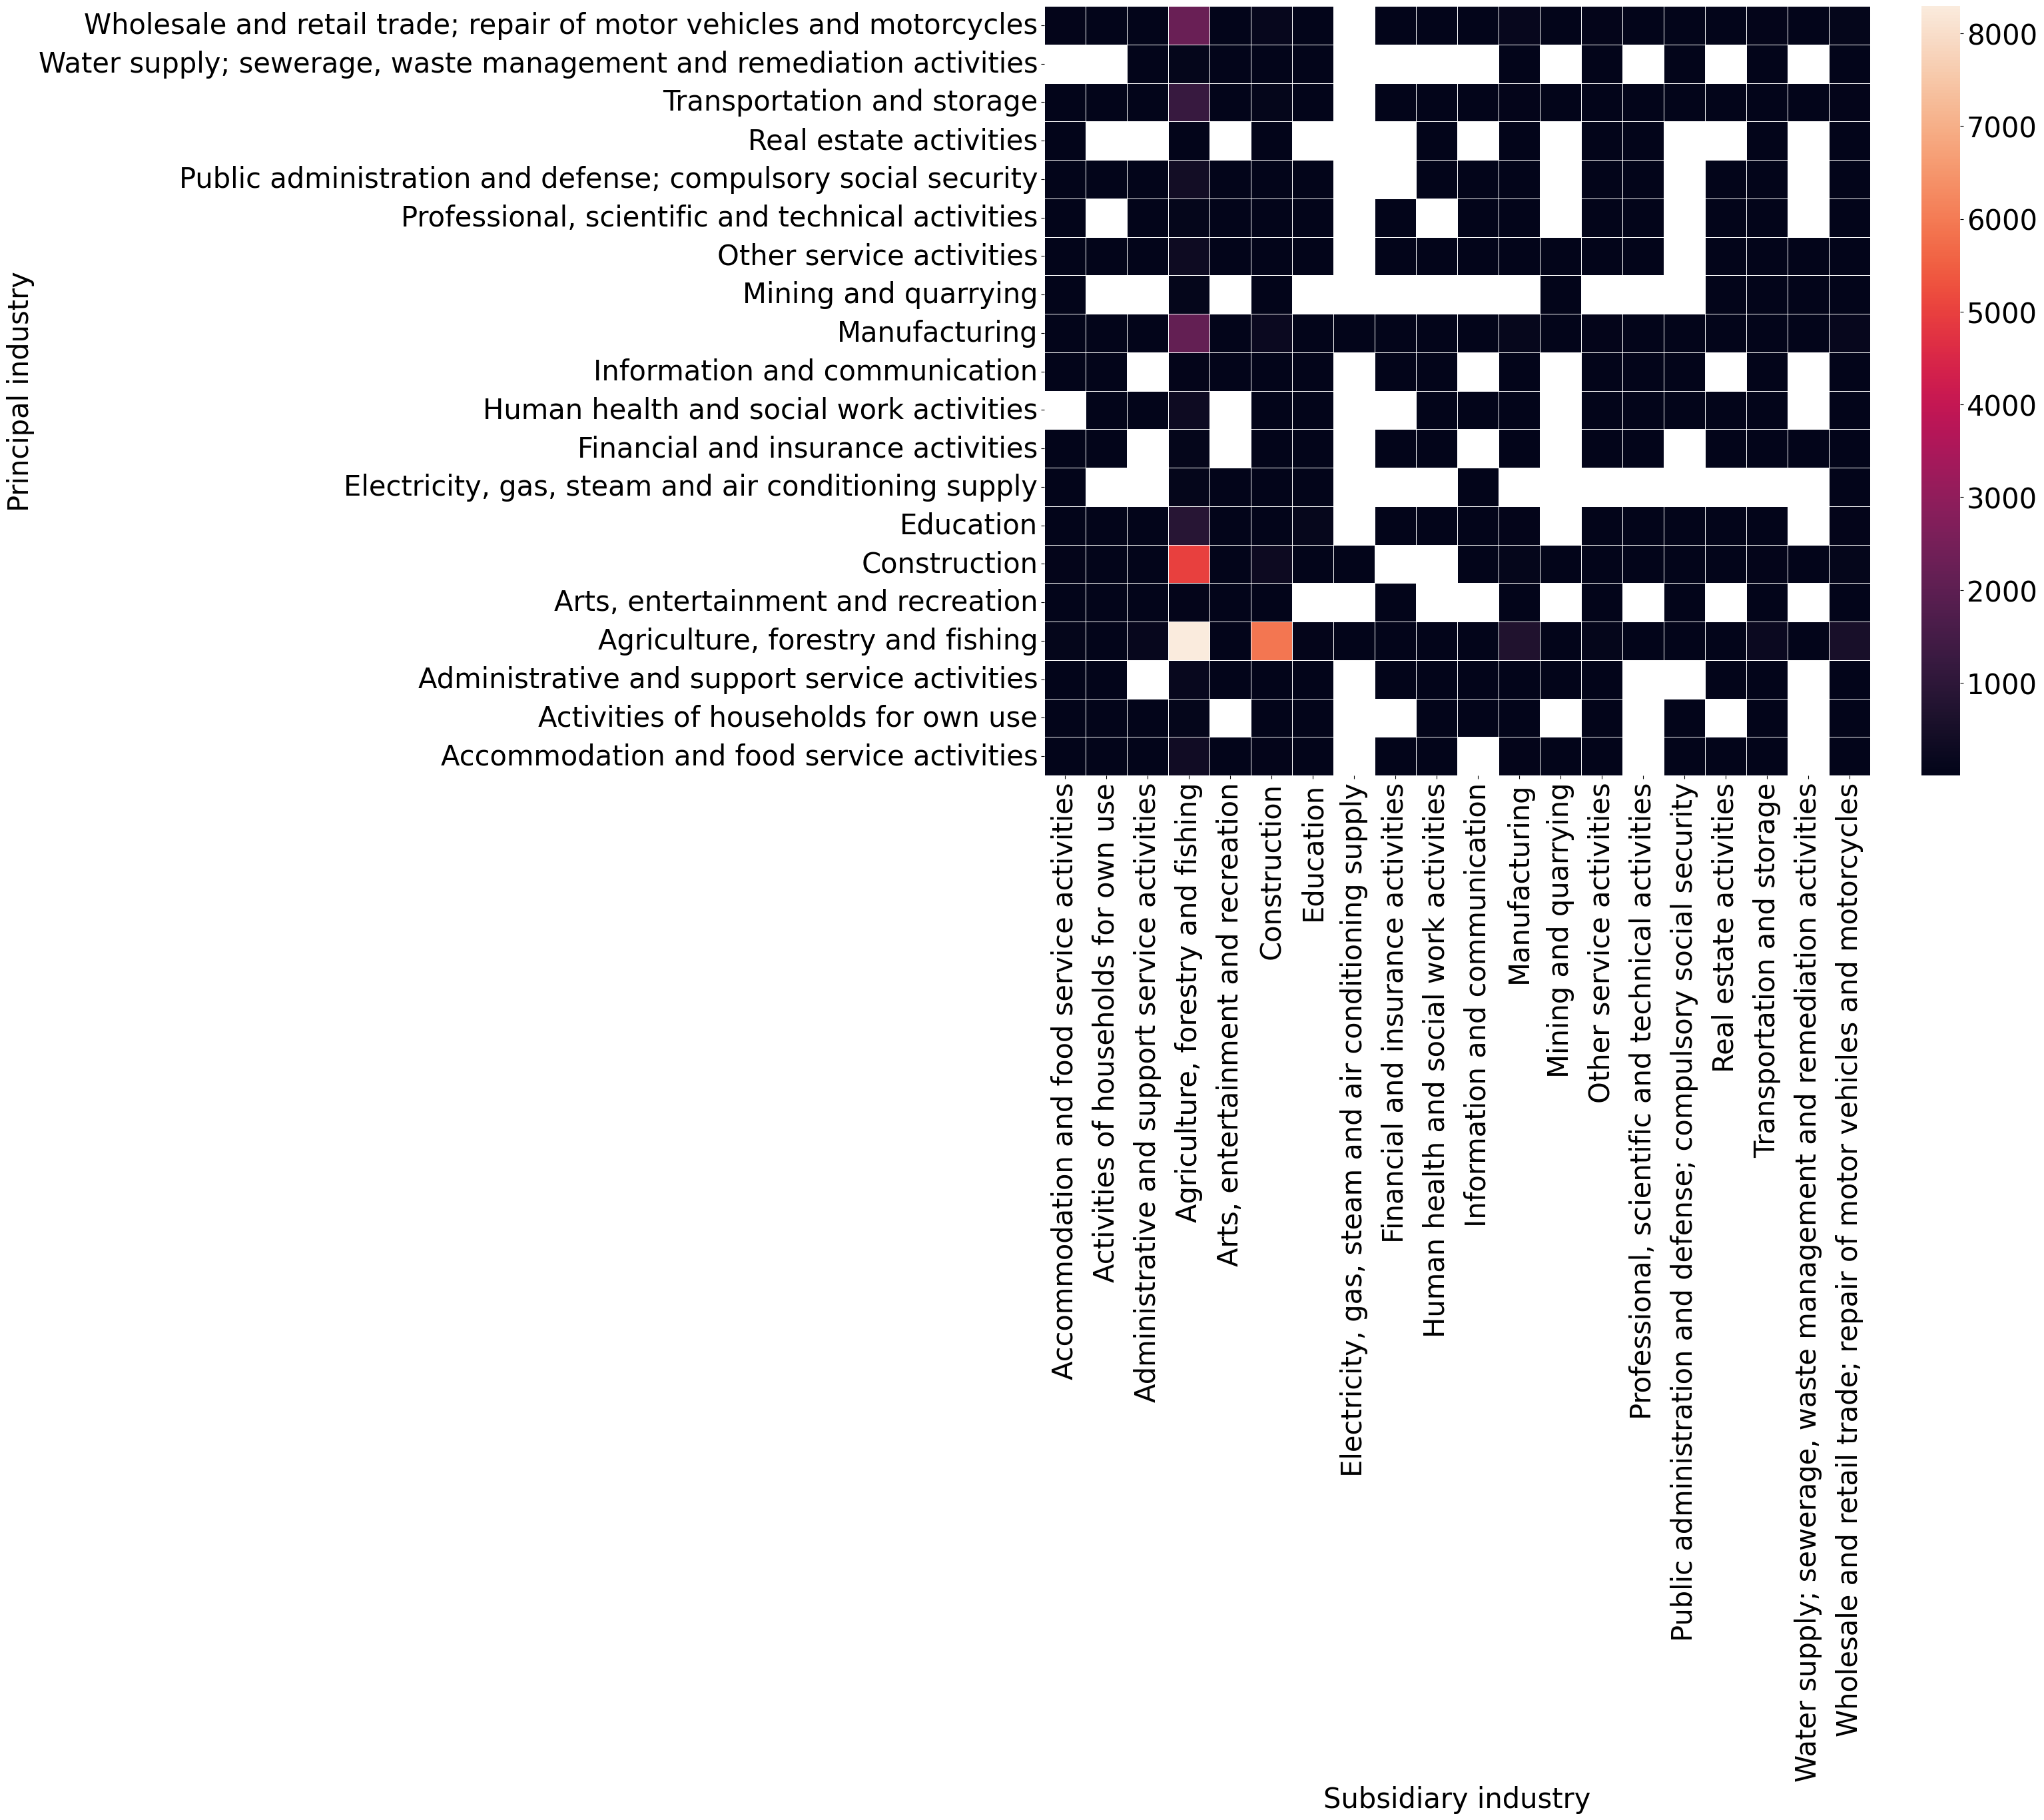

In [38]:
# Plotting heatmap

## Setting up figure size 
plt.figure(figsize=(20, 15))

## Heatmap
heatmap = sns.heatmap(df_filtered, linewidths=0.5)

## Increasing size of axis labels
plt.xlabel("Subsidiary industry", fontsize=30)
plt.ylabel("Principal industry", fontsize=30)

## Increasing size of axis ticks
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=30) #rotation of the labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=30)

## Increasing color bar size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)  # Increase tick label size

# Saving

In [253]:
#Assignign None to empty strings
for col in df.columns:
    if pd.api.types.is_object_dtype(df[col]):                                               #Check if dtype is object
        df[col] = df[col].apply(lambda x: x.strip() if x is not None else x)            # Strips empty spaces
        df[col] = df[col].apply(lambda x: None if x=="" else x)                         # Replace empty strings with None

In [256]:
#Exporting df as pickle file

##Base path
export_base_path = r"G:\Shared drives\Just Transition\Management\Datasets\PLFS 2023-24\Modified data files"

#Saving
df.to_pickle(export_base_path + r'\HHV1_PERV1_merged.pkl')